downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Let me show 40 different people.
images shape: (400, 64, 64), labels shape: (400,)


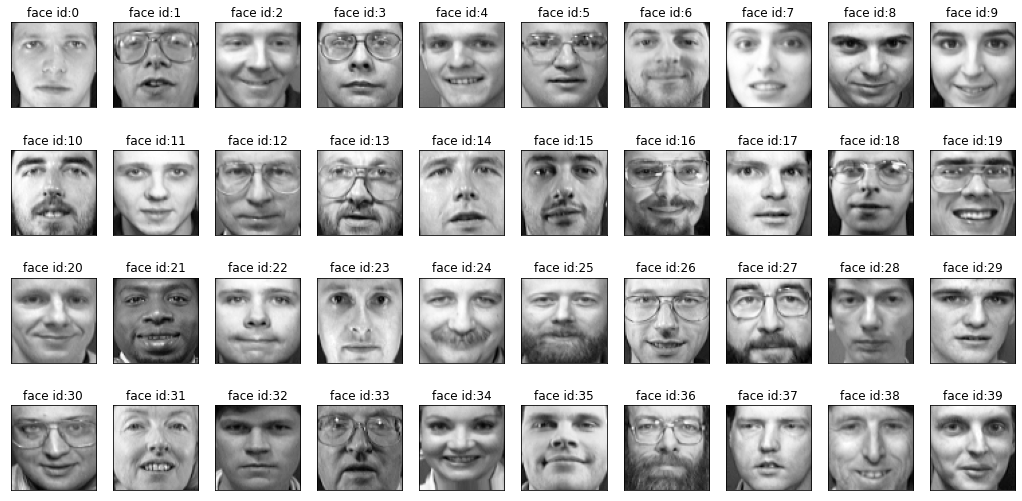

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
import torch

%matplotlib inline

olivetti = fetch_olivetti_faces()
images = olivetti.images
labels = olivetti.target

def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        
print(f"Let me show {len(np.unique(labels))} different people.")
show_40_distinct_people(images, np.unique(labels))

print(f"images shape: {images.shape}, labels shape: {labels.shape}")

In [2]:
def show_10_faces_of_n_subject(images, subject_ids):
    cols=10   # 사람마다 10개의 사진
    rows=(len(subject_ids)*10)/cols 
    rows=int(rows)
    
    fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(18,9))
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index=subject_id*10 + j
            axarr[i,j].imshow(images[image_index], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))

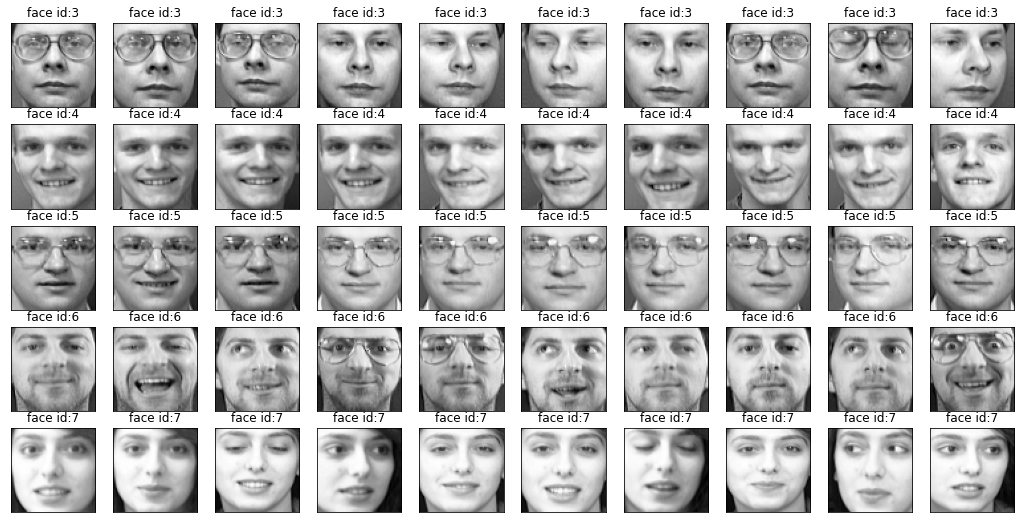

In [3]:
show_10_faces_of_n_subject(images=images, subject_ids=[3,4,5,6,7])

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=0,
                                                   stratify=labels, test_size=0.1)

print(X_train.shape, y_train.shape)

(360, 64, 64) (360,)


In [5]:
import sklearn.datasets
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image
from skimage import io

In [6]:
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.util import invert
from skimage.filters import gaussian
from skimage import exposure

In [7]:
from tqdm import tqdm
X_train_aug = []
y_train_aug = [] 

v_min, v_max = np.percentile(X_train, (1, 99))

for i in tqdm(range(X_train.shape[0])):
    X_train_aug.append(X_train[i])
    X_train_aug.append(rotate(X_train[i], angle=45, mode = 'wrap'))
    X_train_aug.append(rotate(X_train[i], angle=90, mode = 'wrap'))
    X_train_aug.append(np.fliplr(X_train[i]))
    X_train_aug.append(np.flipud(X_train[i]))
    X_train_aug.append(random_noise(X_train[i],var=0.2**2))
    X_train_aug.append(exposure.rescale_intensity(X_train[i], in_range=(v_min, v_max)))
    X_train_aug.append(invert(X_train[i]))
    X_train_aug.append(gaussian(X_train[i], sigma=0.5))
    X_train_aug.append(X_train[i])
    for j in range(10):
        y_train_aug.append(y_train[i])


100%|██████████| 360/360 [00:00<00:00, 961.66it/s]


In [8]:
X_train = np.array(X_train_aug)
y_train = np.array(y_train_aug)

print(X_train.shape, y_train.shape)

(3600, 64, 64) (3600,)


In [9]:
X_train = X_train[:, np.newaxis]
print(X_train.shape)

(3600, 1, 64, 64)


In [10]:
X_train = np.tile(X_train, (1, 3, 1, 1))
X_train.shape

(3600, 3, 64, 64)

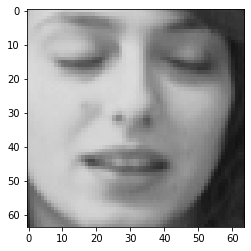

In [11]:
plt.imshow(np.transpose(X_train[360], (1,2,0)))

In [12]:
class FaceDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x_data = torch.from_numpy(x)  ### numpy 배열을 torch 배열로 바꿔줌
        self.y_data = torch.from_numpy(y)
        self.len = len(x)
         
    def __len__(self):
        return (self.len)
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

In [13]:
face_data = FaceDataset(x = X_train, y = y_train)

In [14]:
train_loader = DataLoader(dataset=face_data, 
                          batch_size=36, 
                          shuffle=True, 
                          num_workers=0)

In [22]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [23]:
torch.manual_seed(0)

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
        )

        self.linear_layers = Sequential(
            Linear(128 * 4 * 4, 512),
            ReLU(inplace=True),
            Dropout(),
            Linear(512, 256),
            ReLU(inplace=True),
            Dropout(),
            Linear(256, 128),
            ReLU(inplace=True),
            Dropout(),
            Linear(128, 40)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [24]:
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = CrossEntropyLoss()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Con

In [26]:
print(len(train_loader))
epochs = 20  # epoch 50번

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs
        labels = labels

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9: 
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        

print('Finished Training')

100
[1,    10] loss: 3.813
[1,    20] loss: 3.720
[1,    30] loss: 3.696
[1,    40] loss: 3.712
[1,    50] loss: 3.650
[1,    60] loss: 3.664
[1,    70] loss: 3.558
[1,    80] loss: 3.529
[1,    90] loss: 3.582
[1,   100] loss: 3.476
[2,    10] loss: 3.464
[2,    20] loss: 3.414
[2,    30] loss: 3.344
[2,    40] loss: 3.225
[2,    50] loss: 3.141
[2,    60] loss: 3.118
[2,    70] loss: 3.050
[2,    80] loss: 3.071
[2,    90] loss: 3.031
[2,   100] loss: 2.969
[3,    10] loss: 2.883
[3,    20] loss: 2.818
[3,    30] loss: 2.682
[3,    40] loss: 2.578
[3,    50] loss: 2.588
[3,    60] loss: 2.573
[3,    70] loss: 2.635
[3,    80] loss: 2.617
[3,    90] loss: 2.536
[3,   100] loss: 2.390
[4,    10] loss: 2.328
[4,    20] loss: 2.319
[4,    30] loss: 2.235
[4,    40] loss: 2.176
[4,    50] loss: 2.045
[4,    60] loss: 2.063
[4,    70] loss: 2.217
[4,    80] loss: 1.961
[4,    90] loss: 2.032
[4,   100] loss: 2.000
[5,    10] loss: 1.772
[5,    20] loss: 1.756
[5,    30] loss: 1.624
[5,    

In [33]:
X_test = X_test[:, np.newaxis]
X_test = np.tile(X_test, (1, 3, 1, 1))
print(X_test.shape)

(40, 3, 64, 64)


In [34]:
test_data = FaceDataset(x = X_test, y = y_test)

testloader = DataLoader(dataset=test_data, 
                          batch_size=4, 
                          shuffle=False, 
                          num_workers=0)


In [38]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([4, 3, 64, 64])


In [40]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 95 %
